# Footprint 압력 히트맵 생성

Padoscope로 촬영한 RGB Footprint 이미지를 입력으로 받아 Jet 색상 역변환을 거친 압력 히트맵을 만듭니다.

**왜 역변환이 필요할까요?** Jet 팔레트는 빨강/노랑/파랑 등 여러 색으로 압력을 표현하지만, 이 색을 그대로 밝기로 바꾸면 발가락처럼 빨간 영역이 오히려 어둡게 나옵니다. 따라서 각 픽셀의 색을 다시 0~255 압력 값으로 되돌린 다음 히트맵을 렌더링해야 실제 압력 비율이 유지됩니다.


## 2. 주요 함수 흐름 정리

- **jet_rgb_to_intensity / _get_jet_rgb_lookup**: Jet 팔레트 256단계 RGB 값을 캐시해두고, 각 픽셀을 가장 가까운 색상으로 매칭해 0~255 압력 값으로 역변환합니다.
- **read_rgb_image / display_input_image**: PNG 이미지를 안전하게 RGB로 읽고 원본 화면을 그대로 보여 비교 기준을 만듭니다.
- **rgb_to_pressure_map**: Jet 역변환 또는 그레이스케일로 압력 스칼라를 만든 뒤 배경을 제거하고, `normalization_mode`에 따라 0~255로 정규화하거나 원본 값을 유지합니다. `preserve_jet_intensity=True`(기본값)인 경우 Jet 팔레트에서 얻은 압력 값을 추가 정규화 없이 그대로 사용해 원본 Footprint와 동일한 스케일을 보장합니다.
- **equalize_pressure_map / plot_pressure_heatmap**: 배경 0은 유지한 채 히스토그램 평탄화로 대비를 높이고, 계산된 `value_limits`(수동 입력 또는 실제 min/max)를 사용해 모든 히트맵을 동일한 컬러 스케일로 렌더링합니다.
- **create_pressure_heatmap**: RGB Footprint 이미지를 Jet 역변환해 압력 맵을 만들고, 정규화/평탄화 옵션을 거쳐 히트맵을 저장합니다. `preserve_jet_intensity` 옵션으로 Raw 히트맵이 입력 Footprint 스케일을 유지하도록 제어할 수 있습니다.
- **실행 셀**: 입력 경로, 스케일, 변환 모드 등을 한 곳에서 설정하고 `create_pressure_heatmap`을 호출해 전체 파이프라인을 실행합니다.


In [19]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path
from typing import Optional, Tuple

In [20]:
# Jet 팔레트 역변환에 사용할 RGB 룩업 캐시
_JET_RGB_LOOKUP: Optional[np.ndarray] = None


def _get_jet_rgb_lookup() -> np.ndarray:
    """Jet 컬러맵의 256단계 RGB 값을 미리 계산해 둡니다."""
    global _JET_RGB_LOOKUP
    if _JET_RGB_LOOKUP is None:
        cmap = plt.get_cmap('jet', 256)
        _JET_RGB_LOOKUP = (cmap(np.linspace(0, 1, 256))[:, :3] * 255.0).astype(np.float32)
    return _JET_RGB_LOOKUP


# Jet 색상을 0~255 스칼라 값으로 복원
def jet_rgb_to_intensity(rgb_image: np.ndarray) -> np.ndarray:
    """Jet 컬러 히트맵 이미지를 0~255 강도 맵으로 역변환합니다."""
    lookup = _get_jet_rgb_lookup()
    flat_rgb = rgb_image.reshape(-1, 3).astype(np.float32)
    diffs = np.sum((flat_rgb[:, None, :] - lookup[None, :, :]) ** 2, axis=2)
    # 각 픽셀을 팔레트 256단계와 비교해 가장 가까운 색상의 인덱스를 찾는다.
    indices = np.argmin(diffs, axis=1).astype(np.float32)
    return indices.reshape(rgb_image.shape[:2])


def read_rgb_image(image_path: str) -> np.ndarray:
    """경로를 안전하게 처리해 RGB 이미지를 로드합니다."""
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"입력 파일을 찾을 수 없습니다: {image_path}")

    with open(image_path, 'rb') as f:
        file_bytes = np.fromfile(f, dtype=np.uint8)

    image = cv2.imdecode(file_bytes, cv2.IMREAD_UNCHANGED)
    if image is None:
        raise IOError("cv2.imdecode가 이미지를 디코딩하지 못했습니다.")

    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


def display_input_image(rgb_image: np.ndarray, title: str = 'Input Footprint Image') -> None:
    """입력 이미지를 그대로 시각화해 비교 기준을 제공합니다."""
    plt.figure(figsize=(6, 10))
    plt.imshow(rgb_image)
    plt.title(title)
    plt.axis('off')
    plt.show()


def rgb_to_pressure_map(
    rgb_image: np.ndarray,
    background_threshold: int = 10,
    normalization_mode: str = 'local',
    fixed_normalization_range: Optional[Tuple[float, float]] = None,
    conversion_mode: str = 'grayscale',
    preserve_jet_intensity: bool = True
) -> np.ndarray:
    """
    RGB 이미지를 압력 맵으로 변환합니다.

    Args:
        background_threshold: RGB 채널이 모두 이 값 미만이면 배경으로 간주합니다.
        normalization_mode: 'local' | 'fixed' | 'none' 중 하나를 선택합니다.
            - local: 현재 이미지의 min/max로 0~255 범위로 정규화합니다.
            - fixed: 고정 범위(fixed_normalization_range)를 사용합니다.
            - none : 정규화 없이 원본 값을 유지합니다.
        conversion_mode: 'grayscale'은 회색조, 'jet'은 Jet 역변환을 사용합니다.
        preserve_jet_intensity: conversion_mode='jet'일 때 Jet 색상에서 얻은 압력 값을 추가 정규화 없이 그대로 유지할지 여부입니다.
    """
    normalization_mode = normalization_mode.lower()
    if normalization_mode not in {'local', 'fixed', 'none'}:
        raise ValueError("normalization_mode는 'local', 'fixed', 'none' 중 하나여야 합니다.")

    conversion_mode = conversion_mode.lower()
    if conversion_mode == 'jet':
        base_map = jet_rgb_to_intensity(rgb_image)
        if preserve_jet_intensity and normalization_mode == 'local':
            normalization_mode = 'none'
    elif conversion_mode == 'grayscale':
        base_map = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2GRAY).astype(np.float32)
    else:
        raise ValueError("conversion_mode는 'grayscale' 또는 'jet'만 지원합니다.")

    background_mask = np.all(rgb_image < background_threshold, axis=2)
    pressure_map = np.zeros_like(base_map, dtype=np.float32)
    foreground = base_map[~background_mask]

    if foreground.size > 0:
        foreground_float = foreground.astype(np.float32)
        if normalization_mode == 'none':
            pressure_map[~background_mask] = foreground_float
        else:
            if normalization_mode == 'fixed':
                if fixed_normalization_range is None:
                    raise ValueError("fixed_normalization_range를 지정해야 합니다.")
                min_val, max_val = fixed_normalization_range
            else:
                min_val = foreground_float.min()
                max_val = foreground_float.max()

            if max_val > min_val:
                normalized_foreground = ((foreground_float - min_val) / (max_val - min_val) * 255.0).astype(np.float32)
            else:
                normalized_foreground = np.full_like(foreground_float, 255.0)
            pressure_map[~background_mask] = normalized_foreground

    pressure_map[background_mask] = 0.0
    return pressure_map


def equalize_pressure_map(pressure_map: np.ndarray) -> np.ndarray:
    """배경(0)은 유지하면서 히스토그램 평탄화를 적용해 대비를 높입니다."""
    background_mask = (pressure_map == 0)

    if not np.any(~background_mask):
        return pressure_map.copy()

    pressure_uint8 = pressure_map.astype(np.uint8)

    min_foreground = pressure_uint8[~background_mask].min()
    temp_map = pressure_uint8.copy()
    temp_map[background_mask] = min_foreground if min_foreground > 0 else 1

    equalized_map = cv2.equalizeHist(temp_map).astype(np.float32)
    equalized_map[background_mask] = 0.0
    return equalized_map


def plot_pressure_heatmap(
    pressure_map: np.ndarray,
    output_path: Optional[str],
    cmap_name: str = 'jet',
    title: str = 'Footprint Pressure Heatmap',
    value_limits: Optional[Tuple[float, float]] = None
) -> None:
    """마스킹된 압력 맵을 Jet 컬러맵으로 시각화하고 컬러바 범위를 고정합니다."""
    masked_pressure_map = np.ma.masked_where(pressure_map == 0, pressure_map)

    fig, ax = plt.subplots(figsize=(6, 10))
    cmap = plt.get_cmap(cmap_name)
    cmap.set_bad(color='black')

    vmin = vmax = None
    if value_limits is not None:
        vmin, vmax = value_limits

    im = ax.imshow(masked_pressure_map, cmap=cmap, vmin=vmin, vmax=vmax)
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('Pressure Intensity', rotation=270, labelpad=15)

    ax.set_title(title)
    ax.axis('off')

    if output_path:
        plt.savefig(output_path, bbox_inches='tight', pad_inches=0.1, dpi=300)
        print(f"히트맵이 생성되어 '{output_path}'에 저장되었습니다.")
    plt.show()




def create_pressure_heatmap(
    image_path: str,
    output_path: str = "pressure_heatmap.png",
    use_equalization: bool = True,
    background_threshold: int = 10,
    normalization_mode: str = 'local',
    fixed_normalization_range: Optional[Tuple[float, float]] = None,
    manual_value_limits: Optional[Tuple[float, float]] = None,
    rgb_conversion_mode: str = 'grayscale',
    preserve_jet_intensity: bool = True
) -> None:
    """
    RGB 이미지를 Jet 역변환하거나 그레이스케일로 처리해 히트맵을 생성합니다.

    preserve_jet_intensity가 True이면 Jet 팔레트에서 추출한 압력 값을 추가 정규화 없이 그대로 사용해
    Raw 히트맵이 입력 Footprint와 동일한 스케일을 유지합니다.
    """
    if image_path is None:
        raise ValueError("RGB 이미지 경로가 필요합니다.")

    normalization_mode_lc = normalization_mode.lower()
    rgb_conversion_mode_lc = rgb_conversion_mode.lower()
    preserve_jet_range = (
        rgb_conversion_mode_lc == 'jet'
        and preserve_jet_intensity
        and normalization_mode_lc in {'local', 'none'}
    )

    rgb_image = read_rgb_image(image_path)
    display_input_image(rgb_image, title='Original Footprint Image (RGB)')
    pressure_map = rgb_to_pressure_map(
        rgb_image,
        background_threshold=background_threshold,
        normalization_mode=normalization_mode_lc,
        fixed_normalization_range=fixed_normalization_range,
        conversion_mode=rgb_conversion_mode_lc,
        preserve_jet_intensity=preserve_jet_intensity
    )

    def _resolve_value_limits(map_data: np.ndarray) -> Optional[Tuple[float, float]]:
        """manual_value_limits가 없으면 현재 데이터의 실제 min/max를 사용합니다."""
        if manual_value_limits is not None:
            return manual_value_limits
        if preserve_jet_range:
            return (0.0, 255.0)
        foreground = map_data[map_data > 0]
        if foreground.size == 0:
            return None
        return float(foreground.min()), float(foreground.max())

    base_limits = _resolve_value_limits(pressure_map)
    plot_pressure_heatmap(
        pressure_map,
        None,
        title='Raw Pressure Heatmap (Before Equalization)',
        value_limits=base_limits
    )

    if use_equalization:
        pressure_map = equalize_pressure_map(pressure_map)
        plot_pressure_heatmap(
            pressure_map,
            output_path,
            title='Equalized Pressure Heatmap',
            value_limits=base_limits
        )
    else:
        plot_pressure_heatmap(
            pressure_map,
            output_path,
            title='Pressure Heatmap (No Equalization)',
            value_limits=base_limits
        )




## 3. 스크립트 실행 안내

RGB Footprint 이미지만으로 동작하도록 기본 설정을 구성했습니다. 입력 PNG 경로와 출력 파일명만 바꿔 실행하면 됩니다.


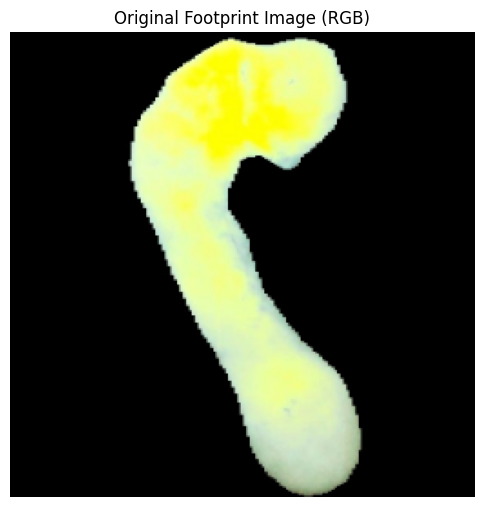

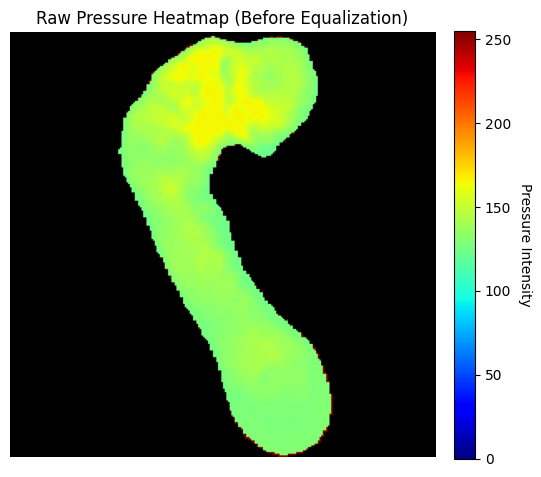

히트맵이 생성되어 'pressure_heatmap.png'에 저장되었습니다.


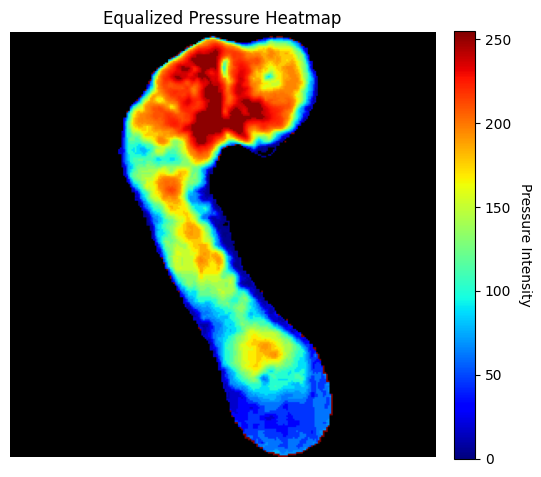

In [21]:

# ===== 사용자 정의 설정 =====
input_image = "test_foot_data/0_Original_Source.png_left_256.png"
# input_image = "test_foot_data/0_Original_Source.png_right_256.png"
output_image = "pressure_heatmap.png"

manual_value_limits = (0, 255)          # 모든 히트맵이 공유할 컬러바 범위
normalization_mode = 'none'             # RGB -> 압력 맵 변환 시 per-image 정규화를 방지
rgb_conversion_mode = 'jet'             # RGB 컬러가 Jet일 때 역변환 경로 사용
background_threshold = 10               # RGB에서 배경으로 취급할 임계값
apply_equalization = True               # 히스토그램 평탄화 적용 여부
preserve_jet_intensity = True           # Jet 색상에서 얻은 압력 값을 그대로 유지할지 여부

create_pressure_heatmap(
    image_path=input_image,
    output_path=output_image,
    use_equalization=apply_equalization,
    background_threshold=background_threshold,
    normalization_mode=normalization_mode,
    manual_value_limits=manual_value_limits,
    rgb_conversion_mode=rgb_conversion_mode,
    preserve_jet_intensity=preserve_jet_intensity
)
